### <font color="orange">E-commerce: описание кейса</font>

📝 Продакт-менеджер попросил проанализировать совершенные покупки и ответить на следующие вопросы:
___

1. Сколько пользователей, которые совершили покупку только один раз?
2. Сколько заказов в месяц в среднем не доставляется по разным причинам? Вывести детализацию по причинам.
3. По каждому товару определить, в какой день недели товар чаще всего покупается.
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? (внутри месяца может быть не целое количество недель, и внутри метрики это нужно учесть) 
5. Выполнить когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3-й месяц. 
6. Построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можно выбрать следующие метрики:  
 - R — время от последней покупки пользователя до текущей даты, 
 - F — суммарное количество покупок у пользователя за всё время,
 - M — сумма покупок за всё время.
___

Для решения задач необходимо провести предварительное исследование данных и сформулировать, что должно считаться покупкой. Обосновать свой выбор можно с помощью фактов оплат, статусов заказов и других имеющихся данных.  

### <font color="orange">E-commerce: решение кейса</font>

<div class='alert alert-info'>
Ознакомимся с файлами для загрузки (файлы хранятся на Яндекс.Диске)
</div>

<font color="blue">**olist_customers_datase.csv**</font> — таблица с уникальными идентификаторами пользователей 

*customer_id — позаказный идентификатор пользователя  
customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)    
customer_zip_code_prefix —  почтовый индекс пользователя    
customer_city —  город доставки пользователя    
customer_state —  штат доставки пользователя*    
___

<font color="blue">**olist_orders_dataset.csv**</font> —  таблица заказов  

*order_id —  уникальный идентификатор заказа (номер чека)  
customer_id —  позаказный идентификатор пользователя  
order_status —  статус заказа  
order_purchase_timestamp —  время создания заказа  
order_approved_at —  время подтверждения оплаты заказа  
order_delivered_carrier_date —  время передачи заказа в логистическую службу  
order_delivered_customer_date —  время доставки заказа  
order_estimated_delivery_date —  обещанная дата доставки*  
___

<font color="blue">**olist_order_items_dataset.csv**</font> — товарные позиции, входящие в заказы  

*order_id —  уникальный идентификатор заказа (номер чека)  
order_item_id —  идентификатор товара внутри одного заказа  
product_id —  ид товара (аналог штрихкода)  
seller_id — ид производителя товара    
shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике  
price —  цена за единицу товара  
freight_value —  вес товара*  
___

**Уникальные статусы заказов в таблице olist_orders_dataset:**

*created —  создан  
approved —  подтверждён  
invoiced —  выставлен счёт  
processing —  в процессе сборки заказа  
shipped —  отгружен со склада  
delivered —  доставлен пользователю  
unavailable —  недоступен  
cancelled —  отменён*  

<div class='alert alert-info'>
Подключим необходимые библиотеки для работы и загрузим файлы
</div>

In [1]:
import requests
from urllib.parse import urlencode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Напишем функцию для чтения файлов с Яндекс-диска и получим загрузочные ссылки
def func_for_download_url(public_key_for_table, base_url='https://cloud-api.yandex.net/v1/disk/public/resources/download?'):
    final_url = base_url + urlencode(dict(public_key=public_key_for_table))
    response = requests.get(final_url)
    return response.json()['href']

download_url_customers = func_for_download_url('https://disk.yandex.ru/d/QXrVDUoQvFhIcg')
download_url_orders = func_for_download_url('https://disk.yandex.ru/d/0zWmh1bYP6REbw')
download_url_order_items = func_for_download_url('https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg')

<div class='alert alert-info'>
Проведем разведочный анализ данных
</div>

#### Таблица с уникальными идентификаторами пользователей: EDA

In [3]:
# customer_id — позаказный идентификатор пользователя
# customer_unique_id —  уникальный идентификатор пользователя (аналог номера паспорта)
# customer_zip_code_prefix —  почтовый индекс пользователя
# customer_city —  город доставки пользователя
# customer_state —  штат доставки пользователя

df_customers = pd.read_csv(download_url_customers)
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
# Определяем размер датафрейма, тип данных в столбцах, наличие пропущенных значений
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [5]:
# Определяем наличие дубликатов
display(df_customers.loc[df_customers.duplicated()])

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


In [6]:
# Изучаем уникальность данных
df_customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [7]:
# Считаем уникальные значения для различных атрибутов с группировкой по customer_unique_id
c_counting = df_customers.groupby('customer_unique_id', as_index=False) \
                         .agg({col: 'nunique' for col in ['customer_id', 'customer_zip_code_prefix',
                                                          'customer_city', 'customer_state']})

# Фильтруем строки, где хотя бы один из параметров больше 1
c_counting.loc[c_counting.iloc[:, 1:] \
          .gt(1).any(axis=1)] \
          .sort_values('customer_id', ascending=False)

,customer_unique_id,customer_id,customer_zip_code_prefix,customer_city,customer_state
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17,1,1,1
23472,3e43e6105506432c953e165fb2acf44c,9,3,1,1
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7,1,1,1
37797,6469f99c1f9dfae7733b25662e7f1782,7,1,1,1
76082,ca77025e7201e3b30c44b472ff346268,7,1,1,1
...,...,...,...,...,...
33730,597e54e653cbc1ce5df1e6d97bbc448c,2,2,2,1
33755,598ef1f13aba15f2b88387184f6c25ec,2,1,1,1
33829,59bba92de9b8f6be0808e4d9d64b4b43,2,1,1,1
33867,59d66d72939bc9497e19d89c61a96d5f,2,1,1,1


In [8]:
# Посмотрим, с данными по какой стране мы имеем дело
df_customers.customer_state.unique()

array(['SP', 'SC', 'MG', 'PR', 'RJ', 'RS', 'PA', 'GO', 'ES', 'BA', 'MA',
       'MS', 'CE', 'DF', 'RN', 'PE', 'MT', 'AM', 'AP', 'AL', 'RO', 'PB',
       'TO', 'PI', 'AC', 'SE', 'RR'], dtype=object)

<div class="alert alert-success">
    
Таблица с уникальными id пользователей содержит 99441 записей и 5 полей. Данные не дублируются, пропущенных значений нет. 
___     
К одному customer_unique_id может относиться несколько позаказных customer_id:      
— кол-во уник. customer_id 99441   
— кол-во уник. customer_unique_id 96096    
___     
С customer_id связаны поля customer_zip_code_prefix, customer_city, customer_state: один и тот же пользователь может заказывать товар по разным адресам, поэтому необходима сущность customer_id. 
___         
Представлены данные по Бразилии. Число городов и штатов свидетельствует о том, что магазин явно работает по всей стране, что говорит о широком покрытии и логистических возможностях.  
</div>

#### Таблица заказов: EDA

In [9]:
# order_id —  уникальный идентификатор заказа (номер чека)
# customer_id —  позаказный идентификатор пользователя
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки
# __________________________________________________________________________________________________________________________

# Уникальные статусы заказов:

# created —  создан
# approved —  подтверждён
# invoiced —  выставлен счёт
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# delivered —  доставлен пользователю
# unavailable —  недоступен
# canceled —  отменён

df_orders = pd.read_csv(download_url_orders, parse_dates=
                        ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                         'order_delivered_customer_date', 'order_estimated_delivery_date'])
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [10]:
# Определяем размер датафрейма, тип данных в столбцах, наличие пропущенных значений
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [11]:
# Есть пропущенные значения: будем с ними осторожнее дальше!
df_orders.isna().sum()                        

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [12]:
# Определяем наличие дубликатов
df_orders.loc[df_orders.duplicated()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [13]:
# Изучаем уникальность данных
df_orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [15]:
# Выбираем только колонки с датами, где есть пропущенные значения
date_cols = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']

# Считаем количество пропусков в разрезе статусов заказов
missing_values_by_status = df_orders.groupby('order_status')[date_cols] \
                                    .apply(lambda x: x.isna().sum()) \
                                    .assign(total_orders=df_orders['order_status'].value_counts()) \
                                    .reset_index()
missing_values_by_status

,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,total_orders
0,approved,0,2,2,2
1,canceled,141,550,619,625
2,created,5,5,5,5
3,delivered,14,2,8,96478
4,invoiced,0,314,314,314
5,processing,0,301,301,301
6,shipped,0,0,1107,1107
7,unavailable,0,609,609,609


In [16]:
# Посмотрим на срок доставки товара по плану(0) и по факту(1)
pd.concat([(df_orders.order_estimated_delivery_date - df_orders.order_purchase_timestamp).describe(), \
           (df_orders.order_delivered_customer_date - df_orders.order_purchase_timestamp).describe()],axis=1)

,0,1
count,99441,96476
mean,23 days 18:25:24.953530234,12 days 13:24:31.879068369
std,8 days 19:58:36.884044268,9 days 13:07:00.181125305
min,1 days 15:34:33,0 days 12:48:07
25%,18 days 07:57:38,6 days 18:23:37.250000
50%,23 days 05:46:08,10 days 05:13:34
75%,28 days 10:11:48,15 days 17:17:16.250000
max,155 days 03:15:04,209 days 15:05:12


<div class="alert alert-success">
    
Таблица заказов содержит 99441 записей и 8 полей. Данные не дублируются. Построчное значение order_id и customer_id уникально.
___           
Есть пропущенные значения в колонках:   
— order_approved_at              (время подтверждения оплаты заказа):            160  
— order_delivered_carrier_date   (время передачи заказа в логистическую службу): 1783  
— order_delivered_customer_date  (время доставки заказа):                        2965      
___     
      
Заказ с любым статусом содержит непустые значения в полях:  
— order_purchase_timestamp      (время создания заказа)  
— order_estimated_delivery_date (обещанная дата доставки)  
___     
      

В данных всего заказов со статусами:   
    
   5/99441 created; все не имеют отметок времени в полях  
— order_approved_at  
— order_delivered_carrier_date  
— order_delivered_customer_date  
___         
2/99441 approved, 314/99441 invoiced, 301/99441 processing, 609/99441 unavailable; все не имеют отметок времени в полях  
— order_delivered_carrier_date  
— order_delivered_customer_date 
___     
1107/99441 shipped; все не имеют отметок времени в поле  
— order_delivered_customer_date
___     
96478/99441 delivered, из них не имеют отметок времени в полях:  
— order_approved_at            14/96478  
— order_delivered_carrier_date  2/96478  
— order_delivered_customer_date 8/96478 
___     
625/99441 canceled, из них не имеют отметок времени в полях:  
— order_approved_at             141/625  
— order_delivered_carrier_date  550/625  
— order_delivered_customer_date 619/625    
___        
    
В среднем планируется доставить товар клиенту за 23 дня, при этом четверть заказов изначально была спланирована со сроком доставки более 4 недель (хотя по факту товар доставляется раньше). Таким образом, мы имеем дело с довольно длительным циклом сделки.

 
</div>

#### Таблица с товарными позициями, входящими в заказы: EDA

In [17]:
# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

df_order_items = pd.read_csv(download_url_order_items, parse_dates=['shipping_limit_date'])
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [18]:
# Определяем размер датафрейма, тип данных в столбцах, наличие пропущенных значений
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [19]:
# Определяем наличие дубликатов
df_order_items.loc[df_order_items.duplicated()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [20]:
# Изучаем уникальность данных
df_order_items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [21]:
# Посмотрим на среднюю стоимость и средний вес товарной единицы
df_order_items.groupby('product_id', as_index=False) \
              .agg({'price': 'mean', 'freight_value': 'mean'}) \
              .describe()

,price,freight_value
count,32951.000000,32951.000000
mean,145.302464,21.202166
std,246.895756,18.089833
min,0.850000,0.010000
25%,39.900000,13.600000
50%,79.000000,16.705000
75%,154.900000,21.828333
max,6735.000000,409.680000


<div class="alert alert-success">
    
Таблица с товарными позициями, входящими в заказы, содержит 112650 записей и 7 полей.  
Данные не дублируются, пропущенных значений нет. 
___     
— кол-во уник. order_id 98666 (отличается от таблицы заказов)  
— кол-во уник. product_id 32951    
— кол-во уник. seller_id 3095     

Если предположить, что вес продукта измерен в килограммах, а цена - в бразильских реалах, то получается, что медианный вес уникальной товарной единицы равен 16.7 кг, а средняя цена - 79 бразильских реал. Это выглядит странным, вероятно, price и freight_value указаны в других единицах измерения.

</div>

#### Создание единого датафрейма и определение методологии

In [25]:
# Визуализируем структуру данных на примере конкретного id заказа
display(df_customers.query("customer_id == '2e45292979b9b2700ea09560eeb0f803'"))
display(df_orders.query("order_id == '00143d0f86d6fbd9f9b38ab440ac16f5'"))
display(df_order_items.query("order_id == '00143d0f86d6fbd9f9b38ab440ac16f5'"))

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
58260,2e45292979b9b2700ea09560eeb0f803,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


In [26]:
# Посчитаем разницу в кол-ве уникальных order_id в таблице заказов и в таблице товарных позиций
df_orders.order_id.nunique()- df_order_items.order_id.nunique()

775

In [27]:
# Сгруппируем по order_id и посчитаем
#     — кол-во товарных позиций в заказе
#     — максимальную shipping_limit_date для заказа (это может понадобиться для сравнения с order_estimated_delivery_date)
#     — total_price, total_freight_value

order_items_temp = df_order_items.groupby(['order_id'], as_index=False) \
                                 .agg({'product_id': 'count', 'shipping_limit_date': 'max', 'price': 'sum', 'freight_value': 'sum'}) \
                                 .rename(columns={'product_id': 'cnt_items', 'shipping_limit_date': 'max_shipping_limit_date',
                                                  'price': 'total_price', 'freight_value':'total_freight_value'})
order_items_temp

,order_id,cnt_items,max_shipping_limit_date,total_price,total_freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1,2018-05-02 04:11:01,299.99,43.41
98662,fffcd46ef2263f404302a634eb57f7eb,1,2018-07-20 04:31:48,350.00,36.53
98663,fffce4705a9662cd70adb13d4a31832d,1,2017-10-30 17:14:25,99.90,16.95
98664,fffe18544ffabc95dfada21779c9644f,1,2017-08-21 00:04:32,55.99,8.72


In [28]:
# Дополним таблицу заказов основной информацией из order_items_temp
df_orders_upd = pd.merge(df_orders, order_items_temp, on='order_id', how='left')
df_orders_upd.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cnt_items,max_shipping_limit_date,total_price,total_freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,2018-02-19 20:31:37,19.90,8.72


In [29]:
# Создадим вспомогательный столбец с отметкой о наличии order_id в таблице товарных позиций 
df_orders_upd['in_order_items'] = df_orders_upd.cnt_items.apply(lambda x: 'yes' if pd.notna(x) else 'no')

In [30]:
# Посмотрим на наличие заказа в таблице товарных позиций в разрезе статусов
df_orders_upd.groupby(['order_status', 'in_order_items'], as_index=False)['order_id'].count() \
             .pivot(index='order_status', columns='in_order_items', values='order_id').fillna(0)

in_order_items,no,yes
order_status,,
approved,0.0,2.0
canceled,164.0,461.0
created,5.0,0.0
delivered,0.0,96478.0
invoiced,2.0,312.0
processing,0.0,301.0
shipped,1.0,1106.0
unavailable,603.0,6.0


In [31]:
# Дополним обновленную таблицу заказов данными о пользователях
df_orders_upd = pd.merge(df_orders_upd, df_customers, how='left', on='customer_id')

In [32]:
# Добавим разницу между временем создания заказа и временем доставки товара
df_orders_upd['purchase_delivered_diff'] = df_orders_upd.order_delivered_customer_date - df_orders_upd.order_purchase_timestamp

In [33]:
# Добавим вспомогательный столбец с месяцем доставки заказа покупателю для удобной дальнейшей работы
df_orders_upd['delivered_month'] = df_orders_upd['order_delivered_customer_date'].dt.to_period('M')
df_orders_upd.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cnt_items,max_shipping_limit_date,total_price,total_freight_value,in_order_items,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,purchase_delivered_diff,delivered_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,2017-10-06 11:07:15,29.99,8.72,yes,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,8 days 10:28:40,2017-10


<div class="alert alert-success">
    
Для удобства данные из разных источников были объединены в таблицу df_orders_upd. По каждому заказу зафиксировано:    
    
— кол-во товаров в заказе  
— максимальная shipping_limit_date для всего заказа  
— общая стоимость заказа  
— общий вес товаров в заказе  
— отметка о наличии order_id в таблице товарных позиций   
— все данные из таблицы с уникальными идентификаторами пользователей  
— разница между временем создания заказа и фактическим временем доставки товара    
— месяц доставки заказа покупателю  
    
</div>

<div class="alert alert-block alert-danger">
Что считать покупкой?
</div>

####  Я считаю, что покупкой корректнее всего признавать заказ, который уже доставлен пользователю. 
Оформление и оплата заказа (и прочие промежуточные этапы до момента доставки товара) — это лишь намерение покупки.
Ни один другой статус не дает основания признать факт покупки экономически, пока товар не будет получен покупателем и пока это не подтверждено  подписью на накладной или другим способом фиксации факта получения.  

Сделка, не имеющая статуса "доставлено покупателю", по итогу может и не состояться. Могут возникнуть непредвиденные обстоятельства в процессе сборки заказа, товар по итогу может быть не отгружен со склада по самым разным причинам, или же возникнут сложности при доставке логистической службой, покупателя может не оказаться дома в запланированный день вручения заказа, товар может доехать в неподобающем виде и будет не принят пользователем и т.д.

In [34]:
# Посмотрим на заказы со статусом "delivered", не имеющие отметок времени в каком-либо из полей
delivered_control = df_orders_upd[(df_orders_upd['order_status'] == 'delivered') & 
                                   df_orders_upd[['order_approved_at', 'order_delivered_carrier_date', 
                                                  'order_delivered_customer_date']].isna().any(axis=1)]
display(delivered_control.head(3))
display(delivered_control.shape)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cnt_items,max_shipping_limit_date,total_price,total_freight_value,in_order_items,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,purchase_delivered_diff,delivered_month
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18,1.0,2017-12-04 17:56:40,117.3,17.53,yes,13467e882eb3a701826435ee4424f2bd,18520,cerquilho,SP,NaT,NaT
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,1.0,2017-02-22 13:40:00,309.9,39.11,yes,8a9a08c7ca8900a200d83cf838a07e0b,6708,cotia,SP,10 days 22:45:33,2017-03
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,1.0,2017-02-22 11:45:31,379.0,17.86,yes,91efb7fcabc17925099dced52435837f,93548,novo hamburgo,RS,11 days 21:19:35,2017-03


(23, 19)

Есть 23 случая, когда по заказам со статусом delivered проставлены не все отметки времени на каждом этапе доставки.  
    
Отсутствие отметок о подтверждении оплаты можно объяснить вероятностью постоплаты по условиям договора с клиентом.  
А вот отсутствие времени передачи заказа в логистическую службу и времени доставки заказа — куда более странная ситуация.     
    
Предположим, что это какой-то сбой в логах данных. Поэтому нужно принять решение (в условии ограниченности имеющихся вводных), учитывать ли такие заказы в покупках. 

Склоняемся к тому, что не стоит отходить от изначальной методологии учета покупок на основании статуса по доставке (аргументом в пользу такого решения также можно считать наличие данных по всем заказам со статусом "доставлен" в таблице товарных позиций). При этом стоит сделать поправку на наличие отметки о дате доставки для большей надежности.

<div class="alert alert-success">
    
Не меняем подход к учету покупок: покупками считаем все заказы со статусом "delivered", но делаем поправку на наличие отметки о дате доставки. 
</div>

<div class='alert alert-info'>
1. Сколько пользователей, которые совершили покупку только один раз?
</div>

In [35]:
# Создаем датафрейм с данными по всем доставленным заказам (=покупкам)
delivered_orders = df_orders_upd.query("order_status == 'delivered' and order_delivered_customer_date.notna()") 
delivered_orders.shape

(96470, 19)

In [36]:
# Считаем количество заказов, сделанных одним уникальным пользователем
delivered_orders.groupby('customer_unique_id').agg({'order_id':'count'}).order_id.value_counts()

1     90549
2      2573
3       181
4        28
5         9
6         5
7         3
9         1
15        1
Name: order_id, dtype: int64

In [37]:
# Считаем количество заказов, сделанных одним уникальным пользователем (в относительных величинах)
delivered_orders.groupby('customer_unique_id').agg({'order_id':'count'}).order_id.value_counts(normalize=True)

1     0.969995
2     0.027563
3     0.001939
4     0.000300
5     0.000096
6     0.000054
7     0.000032
9     0.000011
15    0.000011
Name: order_id, dtype: float64

<div class="alert alert-success">   
90549 пользователей (97% от числа совершивших покупку), совершали покупку только один раз
</div>

<div class='alert alert-info'>
2. Сколько заказов в месяц в среднем не доставляется по разным причинам?
</div>

Проанализируем заказы, которые не содержатся в таблице delivered_orders с предыдущего шага.  

Ранее была обнаружена аномалия по отсутствию отметки времени доставки заказа (поле order_delivered_customer_date) по некоторым заказам, имеющим статус delivered, и такие кейсы были исключены из признанных сделок. Можно предположить, что также является аномальным наличие заказов с промежуточными статусами, срок получения которых давно истек. Это заказы, которые, согласно статусам, не получены покупателем по бизнес-процессу: invoiced,  shipped, processing, created, approved.

Посмотрим на это подробнее. В этом анализе время будем считать по order_purchase_timestamp, так как оно есть у каждого заказа.

In [38]:
# Создадим датафрейм по недоставленным заказам (df_orders_upd = delivered_orders + undelivered_orders)
undelivered_orders = df_orders_upd.loc[~df_orders_upd['order_id'].isin(delivered_orders['order_id'])]
undelivered_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cnt_items,max_shipping_limit_date,total_price,total_freight_value,in_order_items,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,purchase_delivered_diff,delivered_month
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,1.0,2017-04-19 13:25:17,49.90,16.05,yes,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,NaT,NaT
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,1.0,2018-06-13 04:30:33,14.49,7.87,yes,08fb46d35bb3ab4037202c23592d1259,13215,jundiai,SP,NaT,NaT
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,1.0,2018-08-13 06:15:14,35.00,15.35,yes,c7f8d7b1fffc946d7069574f74c39f4e,88140,santo amaro da imperatriz,SC,NaT,NaT
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,1.0,2017-09-20 14:30:09,125.90,12.38,yes,9f269af9c49244f6ba4a46985a3cfc2e,3436,sao paulo,SP,NaT,NaT
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,1.0,2018-01-18 02:32:30,53.99,15.13,yes,528b011eb7fab3d59c336cc7248eed3a,38600,paracatu,MG,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01,NaN,NaT,NaN,NaN,no,e90598185d2427a35e32ef241a5c04aa,11075,santos,SP,NaT,NaT
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06,1.0,2018-01-19 07:18:05,129.90,14.66,yes,965191786b70912f793e4a777fd623cd,13050,campinas,SP,NaT,NaT
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27,NaN,NaT,NaN,NaN,no,d05c44a138277ad325d915c6b7ccbcdf,5344,sao paulo,SP,NaT,NaT
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15,NaN,NaT,NaN,NaN,no,e72a90a2b29fe1a8795b284aaaa3246f,22723,rio de janeiro,RJ,NaT,NaT


In [39]:
# Для начала посмотрим на макс. дату в полном датафрейме и посчитаем, сколько месяцев года он включает
max_dt = df_orders_upd[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                        'order_delivered_customer_date']].max().max()
month_periods = df_orders_upd.order_purchase_timestamp.dt.to_period('M').nunique()
max_dt, month_periods

(Timestamp('2018-10-17 17:30:18'), 25)

In [40]:
# Посчитаем сначала общее количество заказов из undelivered_orders в разрезе статусов
# Найдем также долю в общем количестве заказов из полного датафрейма
undelivered_orders_by_status = undelivered_orders.groupby(['order_status'], as_index=False).order_id.count() \
                                                 .rename(columns={'order_id' : 'total_undelivered_orders'}) \
                                                 .assign(perc_of_all_orders=lambda x: round(x.total_undelivered_orders / 
                                                                                      df_orders_upd.order_id.count() * 100, 2),
                                                         avg_by_month=lambda x: round(x.total_undelivered_orders /
                                                                                 month_periods, 1)) \
                                                 .sort_values('avg_by_month', ascending=False)
undelivered_orders_by_status

,order_status,total_undelivered_orders,perc_of_all_orders,avg_by_month
6,shipped,1107,1.11,44.3
1,canceled,625,0.63,25.0
7,unavailable,609,0.61,24.4
4,invoiced,314,0.32,12.6
5,processing,301,0.30,12.0
3,delivered,8,0.01,0.3
2,created,5,0.01,0.2
0,approved,2,0.00,0.1


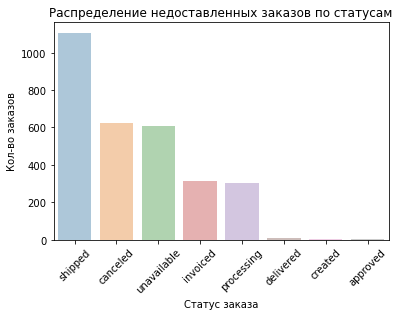

In [41]:
# Визуализируем
sns.barplot(x='order_status', y='total_undelivered_orders', data=undelivered_orders_by_status, alpha=0.4) 
plt.title('Распределение недоставленных заказов по статусам')
plt.xlabel('Статус заказа')
plt.ylabel('Кол-во заказов')
plt.xticks(rotation=45);

In [42]:
# Проверим, есть ли среди undelivered_orders заказы с обещанным сроком больше макс. даты среди отметок времени
undelivered_orders.query("order_estimated_delivery_date > @max_dt & ~order_status.isin(['canceled', 'unavailable'])")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cnt_items,max_shipping_limit_date,total_price,total_freight_value,in_order_items,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,purchase_delivered_diff,delivered_month


Ориентируясь на order_status и наличие отметок времени, классифицируем недоставленные заказы по следующим категориям:
- отменен в процессе создания
- отменен после подтверждения оплаты
- отменен после передачи в логистику
- отменен после доставки покупателю

In [43]:
# Присвоим отметки о наличии дат в разрезе статусов
undelivered_orders.assign(
    approved_date=np.where(undelivered_orders['order_approved_at'].isna(), 'нет', 'есть'),
    delivered_carrier_date=np.where(undelivered_orders['order_delivered_carrier_date'].isna(), 'нет', 'есть'),
    delivered_customer_date=np.where(undelivered_orders['order_delivered_customer_date'].isna(), 'нет', 'есть')) \
    .groupby(['order_status', 'approved_date', 'delivered_carrier_date', 'delivered_customer_date'], as_index=False) \
    .order_id.count()

,order_status,approved_date,delivered_carrier_date,delivered_customer_date,order_id
0,approved,есть,нет,нет,2
1,canceled,есть,есть,есть,6
2,canceled,есть,есть,нет,69
3,canceled,есть,нет,нет,409
4,canceled,нет,нет,нет,141
5,created,нет,нет,нет,5
6,delivered,есть,есть,нет,7
7,delivered,есть,нет,нет,1
8,invoiced,есть,нет,нет,314
9,processing,есть,нет,нет,301


In [44]:
# Присвоим отметки этапов, после которых заказ так и не был завершен
problems = ['отменен в процессе создания', 'отменен после подтверждения оплаты',
            'отменен после передачи в логистику', 'отменен после доставки покупателю']
my_cols = ['order_status', 'reason', 'orders']

my_values = [['approved', problems[1], 2],
             ['canceled', problems[3], 6],
             ['canceled', problems[2], 69],
             ['canceled', problems[1], 409],
             ['canceled', problems[0], 141],
             ['created', problems[0], 5],
             ['delivered', problems[2], 7],
             ['delivered', problems[1], 1],
             ['invoiced', problems[1], 314],
             ['processing', problems[1], 301],
             ['shipped', problems[2], 1107],
             ['unavailable', problems[1], 609]]

undelivered_result = pd.DataFrame(data=my_values, columns=my_cols)
undelivered_result

,order_status,reason,orders
0,approved,отменен после подтверждения оплаты,2
1,canceled,отменен после доставки покупателю,6
2,canceled,отменен после передачи в логистику,69
3,canceled,отменен после подтверждения оплаты,409
4,canceled,отменен в процессе создания,141
5,created,отменен в процессе создания,5
6,delivered,отменен после передачи в логистику,7
7,delivered,отменен после подтверждения оплаты,1
8,invoiced,отменен после подтверждения оплаты,314
9,processing,отменен после подтверждения оплаты,301


In [45]:
# Сгруппируем по причинам отмен
undelivered_result.groupby('reason', as_index=False).orders.sum() \
                  .assign(perc_of_all_orders=lambda x: round(x.orders / df_orders_upd.order_id.count() * 100, 2),
                          avg_by_month=lambda x: round(x.orders / month_periods, 1)) \
                  .sort_values('avg_by_month', ascending=False)

,reason,orders,perc_of_all_orders,avg_by_month
3,отменен после подтверждения оплаты,1636,1.65,65.4
2,отменен после передачи в логистику,1183,1.19,47.3
0,отменен в процессе создания,146,0.15,5.8
1,отменен после доставки покупателю,6,0.01,0.2


<div class="alert alert-success">   
3% заказов Интернет-магазина не доставляются. Из них:    
    
—  1.65% до этапа передачи в логистику и непосредственно доставки (отмена после подтверждения оплаты)  
—  1.19% после передачи в логистику (на этапе доставки)  
—  менее 1% отменяется в процессе создания и после доставки   

</div>

<div class='alert alert-info'>
3. По каждому товару определить, в какой день недели товар чаще всего покупается
</div>

Чтобы оценить спрос на конкретную товарную позицию без влияния прочих факторов, логично изучить, в какой день недели покупатели создают заказ чаще всего (перефразируем вопрос, всё-таки это не покупка согласно выбранной ранее методологии). Для этого обратимся к изначальной таблице с товарными позициями, немного ее дополнив.

In [46]:
# Дополним датафрейм с товарными позициями датой создания заказа и отдельно создадим столбец с днем недели
df_order_items_upd = df_order_items.merge(df_orders[['order_id', 'order_purchase_timestamp']],
                                          how='left', on='order_id') \
                                   .assign(purchase_day = lambda x: x.order_purchase_timestamp.dt.day_name()) 
df_order_items_upd.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,purchase_day
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,2017-09-13 08:59:02,Wednesday


In [47]:
# Для каждого товара находим день недели (дни, если таких несколько), когда товар чаще всего покупается
frequency_of_purchases = df_order_items_upd.groupby(['product_id']).purchase_day.agg(pd.Series.mode).reset_index()
frequency_of_purchases

,product_id,purchase_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,"[Saturday, Sunday]"
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


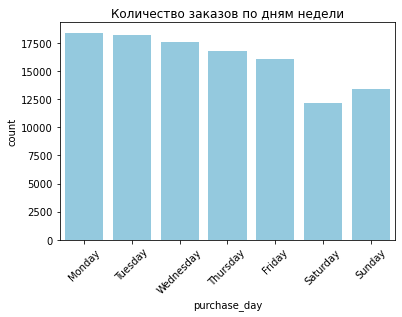

In [49]:
#Визуализируем общую картину
sns.countplot(x='purchase_day', data=df_order_items_upd, color='skyblue', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
plt.xticks(rotation=45)
plt.title('Количество заказов по дням недели');

<div class="alert alert-success">   
Чаще всего наши пользователи создают заказ в первую половину недели.
</div>

<div class='alert alert-info'>
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
</div>

Обратимся к таблице delivered_orders с данными по заказам, которые мы посчитали покупками на первом шаге (успешно завершенные)

In [50]:
# Посчитаем количество заказов по customer_unique_id и месяцу покупки, добавим столбец с кол-вом дней в месяце года
delivered_orders_by_month = delivered_orders.groupby(['customer_unique_id', 'delivered_month'], as_index=False) \
                                            .agg(orders=('order_id', 'count')) \
                                            .assign(days_in_month = lambda x: x.delivered_month.dt.daysinmonth)
delivered_orders_by_month

,customer_unique_id,delivered_month,orders,days_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,31
2,0000f46a3911fa3c0805444483337064,2017-04,1,30
3,0000f6ccb0745a6a4b88665a16c9f078,2017-11,1,30
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,30
...,...,...,...,...
95301,fffcf5a5ff07b0908bd4e2dbc735a684,2017-07,1,31
95302,fffea47cd6d3cc0a88bd621562a9d061,2018-01,1,31
95303,ffff371b4d645b6ecea244b27531430a,2017-02,1,28
95304,ffff5962728ec6157033ef9805bacc48,2018-05,1,31


In [51]:
# Найдем мин. и макс. дату по столбцу order_delivered_customer_date
min_ddate = df_orders_upd.order_delivered_customer_date.min()
max_ddate = df_orders_upd.order_delivered_customer_date.max()

min_ddate, max_ddate

(Timestamp('2016-10-11 13:46:32'), Timestamp('2018-10-17 13:22:46'))

In [52]:
# Скорректируем кол-во дней в первом и последнем месяце, так как данные по ним не полные
delivered_orders_by_month.loc[delivered_orders_by_month.delivered_month == min_ddate.to_period('M'), 'days_in_month'] = \
                              min_ddate.days_in_month - (min_ddate.day - 1)
delivered_orders_by_month.loc[delivered_orders_by_month.delivered_month == max_ddate.to_period('M'), 'days_in_month'] = \
                              max_ddate.day

In [53]:
# Посчитаем, cколько у каждого из пользователей в среднем покупок в неделю (по месяцам)
delivered_orders_by_month.assign(mean_purchases=lambda x: x.orders / x.days_in_month * 7) \
                         .sort_values(['customer_unique_id', 'delivered_month'])

,customer_unique_id,delivered_month,orders,days_in_month,mean_purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,31,0.225806
2,0000f46a3911fa3c0805444483337064,2017-04,1,30,0.233333
3,0000f6ccb0745a6a4b88665a16c9f078,2017-11,1,30,0.233333
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,30,0.233333
...,...,...,...,...,...
95301,fffcf5a5ff07b0908bd4e2dbc735a684,2017-07,1,31,0.225806
95302,fffea47cd6d3cc0a88bd621562a9d061,2018-01,1,31,0.225806
95303,ffff371b4d645b6ecea244b27531430a,2017-02,1,28,0.250000
95304,ffff5962728ec6157033ef9805bacc48,2018-05,1,31,0.225806


<div class='alert alert-info'>
5. Когортный анализ пользователей
</div>

Когорту будут составлять пользователи, которые успешно завершили свой первый заказ в определенном месяце (пользователи, которым первый заказ был доставлен в определенном месяце).  
Сформируем когорты на основании поля order_delivered_customer_date (затронем период с января по декабрь 2017 года), проанализируем Retention Rate и выявим когорту с самым высоким retention на 3-й месяц.

In [54]:
# Отфильтруем данные из таблицы delivered orders: добавим поле с когортой и оставим только когорты 2017 года
for_cohort_analysis = delivered_orders.assign(cohort=lambda x: x.groupby('customer_unique_id').delivered_month.transform(min)) \
                                      .query('cohort.dt.year == 2017')[['customer_unique_id', 'cohort', 'delivered_month']]
                                      
for_cohort_analysis

,customer_unique_id,cohort,delivered_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-09,2017-10
3,7c142cf63193a1473d2e66489a9ae977,2017-12,2017-12
5,80bb27c7c16e8f973207a5086ab329e2,2017-07,2017-07
7,932afa1e708222e5821dac9cd5db4cae,2017-05,2017-05
8,39382392765b6dc74812866ee5ee92a7,2017-02,2017-02
...,...,...,...
99433,c716cf2b5b86fb24257cffe9e7969df8,2017-10,2017-10
99434,e03dbdf5e56c96b106d8115ac336f47f,2017-02,2017-02
99435,831ce3f1bacbd424fc4e38fbd4d66d29,2017-03,2017-03
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03,2017-03


In [55]:
# Сгруппируем данные по когорте и месяцу доставки и посчтаем кол-во пользователей, совершивших покупку в определенном месяце
# Подсчитаем порядковый номер delivered_month для каждой когорты
cohort_result = for_cohort_analysis.groupby(['cohort', 'delivered_month'], as_index=False)['customer_unique_id'].nunique() \
                                   .assign(period = lambda x: x.delivered_month.apply(lambda x: x.ordinal) -
                                                              x.cohort.apply(lambda x: x.ordinal))
                                   
cohort_result

,cohort,delivered_month,customer_unique_id,period
0,2017-01,2017-01,263,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,1,2
3,2017-01,2017-05,1,4
4,2017-01,2017-06,1,5
...,...,...,...,...
161,2017-12,2018-04,14,4
162,2017-12,2018-05,9,5
163,2017-12,2018-06,12,6
164,2017-12,2018-07,10,7


In [56]:
# Преобразуем в таблицу pivot
cohort_retention = cohort_result.pivot(index='cohort', columns='period', values='customer_unique_id') \
                                .apply(lambda x: x.div(x[0]), axis=1)
cohort_retention

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cohort,,,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.011407,0.003802,NaN,0.003802,0.003802,0.003802,0.003802,NaN,NaN,0.003802,0.007605,0.011407,NaN,0.003802,NaN,NaN,0.007605,NaN,0.003802
2017-02,1.0,0.006792,0.002264,0.003019,0.003019,0.001509,0.001509,0.002264,0.000755,0.000755,0.001509,0.003774,0.002264,0.001509,0.000755,0.001509,0.002264,NaN,0.000755,NaN
2017-03,1.0,0.005546,0.002986,0.004266,0.002986,0.000853,0.002986,0.002560,0.002986,0.002133,0.002560,0.000427,0.000427,0.002986,0.001280,0.001706,0.001280,0.000853,NaN,NaN
2017-04,1.0,0.007761,0.002772,0.002217,0.002772,0.001663,0.002772,0.000554,0.003880,0.002217,0.002772,0.001109,NaN,0.001109,0.001109,0.001663,0.001663,NaN,NaN,NaN
2017-05,1.0,0.007351,0.003267,0.001634,0.003539,0.003812,0.002450,0.003539,0.002178,0.002178,0.002450,0.002995,0.001361,0.001634,0.001906,0.002178,NaN,NaN,NaN,NaN
2017-06,1.0,0.007042,0.005762,0.004481,0.003521,0.002561,0.003841,0.001921,0.001921,0.002241,0.001601,0.001921,0.002241,0.002241,0.002561,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.006557,0.001788,0.004173,0.002683,0.002683,0.003875,0.002683,0.002086,0.002683,0.003279,0.004471,0.000894,0.003279,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006721,0.004801,0.001920,0.003120,0.005281,0.002400,0.002400,0.001920,0.001680,0.002400,0.001200,0.001680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.010699,0.002871,0.004175,0.004175,0.002871,0.002349,0.003132,0.002088,0.002610,0.001827,0.002088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


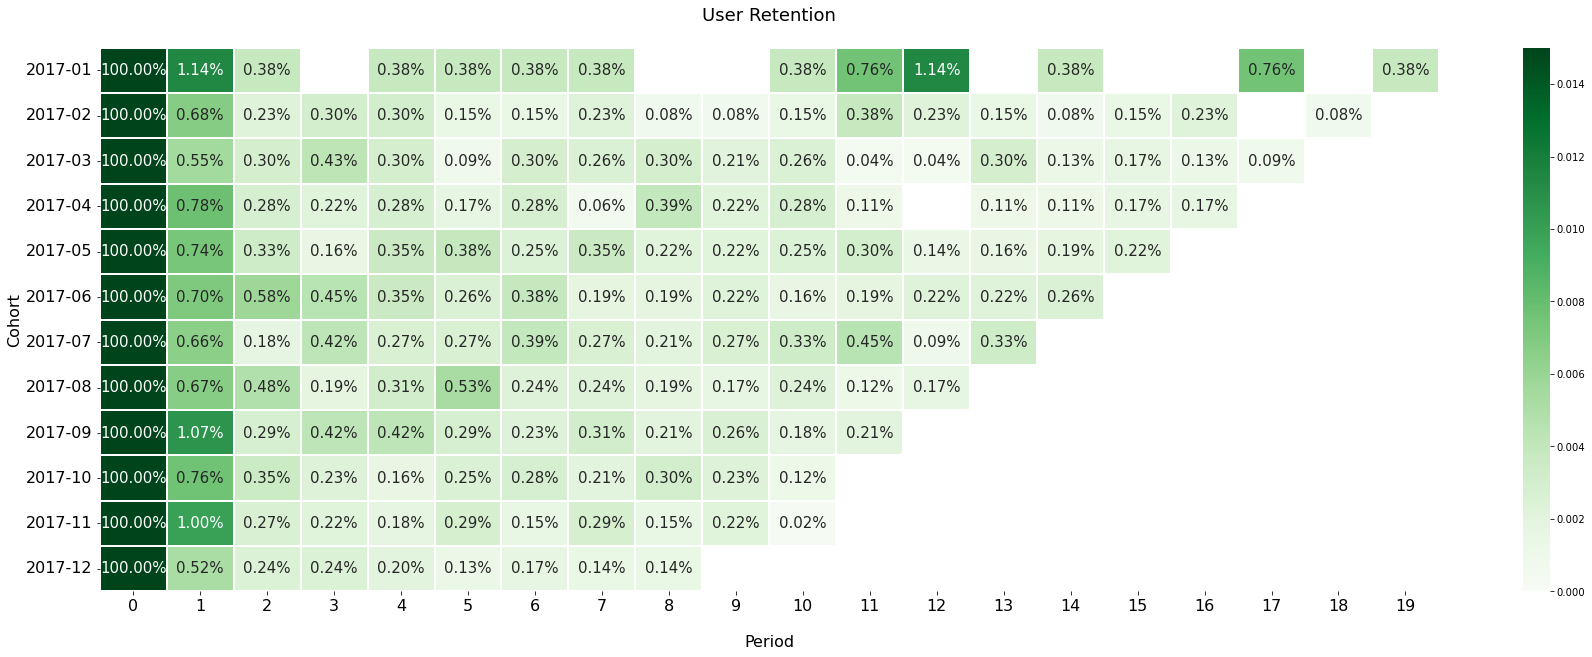

In [57]:
# Визуализируем результат
plt.figure(figsize=(30, 10))
sns.heatmap(cohort_retention, annot=True, fmt='.2%', cmap="Greens", \
            vmin=0, vmax=0.015, linewidths=1.5, linecolor='white', 
            annot_kws={"fontsize": 15});

plt.xlabel('\nPeriod', fontsize=16)  
plt.ylabel('Cohort', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(rotation=360, fontsize=16)
plt.title('User Retention\n', fontsize=18);

In [58]:
# Найдем максимальное значение retention в 3 периоде
cohort_retention[[3]].idxmax()

period
3    2017-06
dtype: period[M]

<div class="alert alert-success">   
Согласно выбранному подходу к когортному анализу максимальное значение Retention rate на 3-й месяц у пользователей, совершивших первую покупку в июне 2017 года
</div>

<div class='alert alert-info'>
6. RFM-анализ пользователей
</div>

Построим RFM-сегментацию пользователей, чтобы качественно оценить аудиторию. Ответим на вопросы

1. Recency (Давность). Как давно клиент совершил покупку?
2. Frequency (Частота) Как часто клиенты совершают покупки?
3. Monetary Value (Денежная ценность) Сколько клиенты тратят?

In [59]:
# Сохраним необходимые для RFM-анализа данные в отдельный датафрейм
for_RFM_analysis = delivered_orders[['customer_unique_id', 'order_id', 'order_delivered_customer_date', 'delivered_month', 'total_price']]
for_RFM_analysis.head(1)

,customer_unique_id,order_id,order_delivered_customer_date,delivered_month,total_price
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10,29.99


In [60]:
# Определим дату, от которой будем отсчитывать последнюю покупку. Возьмем макс. дату из order_delivered_customer_date
now_date = for_RFM_analysis.order_delivered_customer_date.max()

In [61]:
# По customer_unique_id посчитаем, как давно клиент совершил покупку, кол-во заказов и суммарную выручку
for_RFM_analysis_table = for_RFM_analysis.groupby(['customer_unique_id'], as_index=False) \
                                         .agg({'order_delivered_customer_date': lambda x: (now_date - x.max()).days,
                                               'order_id':'count',
                                               'total_price':'sum'}) \
                                         .rename(columns={'order_delivered_customer_date':'recency', 
                                                          'order_id':'frequency',
                                                          'total_price':'monetary_value'})
for_RFM_analysis_table 

,customer_unique_id,recency,frequency,monetary_value
0,0000366f3b9a7992bf8c76cfdf3221e2,153,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159,1,18.90
2,0000f46a3911fa3c0805444483337064,559,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,349,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,323,1,180.00
...,...,...,...,...
93345,fffcf5a5ff07b0908bd4e2dbc735a684,468,1,1570.00
93346,fffea47cd6d3cc0a88bd621562a9d061,280,1,64.89
93347,ffff371b4d645b6ecea244b27531430a,602,1,89.90
93348,ffff5962728ec6157033ef9805bacc48,156,1,115.00


In [62]:
# Посмотрим на описательные статистики
for_RFM_analysis_table.describe()

,recency,frequency,monetary_value
count,93350.000000,93350.000000,93350.000000
mean,273.145817,1.033423,141.620235
std,151.963456,0.209106,215.702028
min,0.000000,1.000000,0.850000
25%,152.000000,1.000000,47.650000
50%,252.000000,1.000000,89.700000
75%,383.000000,1.000000,154.697500
max,735.000000,15.000000,13440.000000


Необходимо определиться с подходом к сегментации. Стандартное деление на квантили распределения не по всем метрикам выглядит рациональным, особенно это заметно на примере показателя frequency, поскольку практически все юзеры совершают только одну покупку.

**recency**

Вернемся к показателю recency. Здесь ранговую систему нужно строить на обратной логике, поскольку чем меньше дней прошло с момента последней покупки, тем лучше.

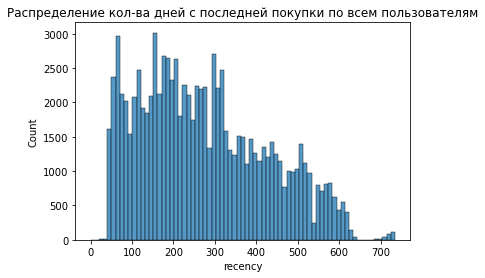

In [65]:
# Визуализируем распределение давности покупок
sns.histplot(data=for_RFM_analysis_table, x="recency")
plt.title('Распределение кол-ва дней с последней покупки по всем пользователям');

In [66]:
# 25-й, 50-й и 75-й процентиль отличимы и вполне полходят для выделения сегментов
for_RFM_analysis_table.recency.describe()

count    93350.000000
mean       273.145817
std        151.963456
min          0.000000
25%        152.000000
50%        252.000000
75%        383.000000
max        735.000000
Name: recency, dtype: float64

**Присвоим ранги показателю recency следующим образом:**

- 1 балл: 383 дня и более
- 2 балла: 252 дня - 382 дня
- 3 балла: 152 дня - 251 день
- 4 балла: до 151 дня включительно

In [67]:
# Создадим новые столбцы в датафрейме for_RFM_analysis_table с рангом recency   
def rec(x):
    return 4 if x <= 151 else 3 if x <= 251 else 2 if x <= 382 else 1

for_RFM_analysis_table['R'] = for_RFM_analysis_table.recency.apply(rec)

**frequency**

In [69]:
# Посмотрим на частоту покупок и количество юзеров
for_RFM_analysis_table.groupby(['frequency'], as_index=False).customer_unique_id.count()

,frequency,customer_unique_id
0,1,90549
1,2,2573
2,3,181
3,4,28
4,5,9
5,6,5
6,7,3
7,9,1
8,15,1


**Присвоим ранги показателю frequency следущим образом:**

- 1 балл: 1 заказ
- 2 балла: 2 заказа
- 3 балла: 3 заказа
- 4 балла: 4 заказа и более

In [70]:
# Создадим новый столбец в датафрейме for_RFM_analysis_table с рангом frequency
for_RFM_analysis_table['F'] = for_RFM_analysis_table.frequency.apply(lambda x: x if x in (1,2,3) else 4)

**monetary**

Определяемся, на чем будет строиться ранговая система по показателю monetary

In [71]:
# 25-й, 50-й и 75-й процентиль отличимы и вполне полходят для выделения сегментов
for_RFM_analysis_table.monetary_value.describe()

count    93350.000000
mean       141.620235
std        215.702028
min          0.850000
25%         47.650000
50%         89.700000
75%        154.697500
max      13440.000000
Name: monetary_value, dtype: float64

**Присвоим ранги показателю monetary_value следующим образом:**

- 1 балл: 48 и менее
- 2 балла: 49 - 90
- 3 балла: 91 - 155
- 4 балла: 156 и более

In [72]:
# Создадим новые столбцы в датафрейме for_RFM_analysis_table с рангом monetary_value   
def mon(x):
    return 1 if x <= 48 else 2 if x <= 90 else 3 if x <= 155 else 4

for_RFM_analysis_table['M'] = for_RFM_analysis_table.monetary_value.apply(mon)
for_RFM_analysis_table.head()

,customer_unique_id,recency,frequency,monetary_value,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,153,1,129.90,3,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159,1,18.90,3,1,1
2,0000f46a3911fa3c0805444483337064,559,1,69.00,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,349,1,25.99,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,323,1,180.00,2,1,4


**Анализ сегментов**

In [73]:
# Добавим столбец с сегментом
for_RFM_analysis_table['RFMClass'] = for_RFM_analysis_table[['R', 'F', 'M']].apply(lambda x: ''.join(x.astype(str)), axis=1)
for_RFM_analysis_table

,customer_unique_id,recency,frequency,monetary_value,R,F,M,RFMClass
0,0000366f3b9a7992bf8c76cfdf3221e2,153,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,559,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,349,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,323,1,180.00,2,1,4,214
...,...,...,...,...,...,...,...,...
93345,fffcf5a5ff07b0908bd4e2dbc735a684,468,1,1570.00,1,1,4,114
93346,fffea47cd6d3cc0a88bd621562a9d061,280,1,64.89,2,1,2,212
93347,ffff371b4d645b6ecea244b27531430a,602,1,89.90,1,1,2,112
93348,ffff5962728ec6157033ef9805bacc48,156,1,115.00,3,1,3,313


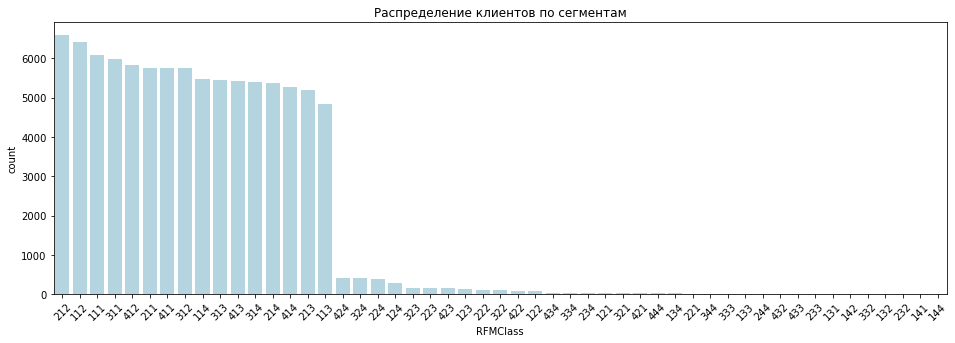

In [78]:
# Визуализируем распределение клиентов по сегментам
plt.figure(figsize=(16,5));
sns.countplot(x='RFMClass',
              data=for_RFM_analysis_table,
              order=for_RFM_analysis_table['RFMClass'].value_counts().index, color='lightblue')
plt.xticks(rotation=45)
plt.title('Распределение клиентов по сегментам');

Объединим для большей информативности 64 сегмента в 12 групп.

In [75]:
# покупали давно (1,2), покупали редко (1), приносили мало денег (1)
# покупали давно (1,2), покупали редко (1), приносили достаточно денег (2,3)
# покупали давно (1,2), покупали редко (1), приносили много денег (4)

# покупали давно (1,2), покупали часто (2,3,4), приносили мало денег (1)
# покупали давно (1,2), покупали часто (2,3,4), приносили достаточно денег (2,3)
# покупали давно (1,2), покупали часто (2,3,4), приносили много денег (4)
#__
# покупали недавно (3,4), покупали редко (1), приносили мало денег (1)
# покупали недавно (3,4), покупали редко (1), приносили достаточно денег (2,3)
# покупали недавно (3,4), покупали редко (1), приносили много денег (4)

# покупали недавно (3,4), покупали часто (2,3,4), приносили мало денег (1)
# покупали недавно (3,4), покупали часто (2,3,4), приносили достаточно денег (2,3)
# покупали недавно (3,4), покупали часто (2,3,4), приносили много денег (4)

# давность: - +
# частота:  - +
# деньги: - + $

def new_segments(x):    
    if x in ('111', '211'):
        return '---'  # покупали давно, редко, приносили мало денег      
    
    elif x in ('112', '113', '212', '213'):
        return '--+'  # покупали давно, редко, приносили достаточно денег   
    
    elif x in ('114', '214'):
        return '--$'  # покупали давно, редко, приносили много денег    
    
    elif x in ('141', '131', '121', '241', '231', '221'):
        return '-+-'  # покупали давно, часто, приносили мало денег  
    
    elif x in ('122','123','132','133','142','143','222','223','232','233','242','243'):
        return '-++'  # покупали давно, часто, приносили достаточно денег 
    
    elif x in ('124','134','144', '224','234','244'):
        return '-+$'  # покупали давно, часто, приносили много денег    
    
    elif x in ('311', '411'):
        return '+--'  # покупали недавно, редко, приносили мало денег    
    
    elif x in ('312', '313', '412', '413'):
        return '+-+'  # покупали недавно, редко, приносили достаточно денег    
    
    elif x in ('314', '414'):
        return '+-$'  # покупали недавно, редко, приносили много денег    
    
    elif x in ('321','331','341','421','431','441'): 
        return '++-'  # покупали недавно, часто, приносили мало денег    
    
    elif x in ('322','323','332','333','342','343','422','423','432','433','442','443'):
        return '+++'  # покупали недавно, часто, приносили достаточно денег    
    
    elif x in ('324','334','344','424','434','444'):
        return '++$'  # покупали недавно, часто, приносили много денег    
    else:
        return 'Unknown'    
    
for_RFM_analysis_table['new_segment'] = for_RFM_analysis_table['RFMClass'].apply(new_segments)

In [76]:
# Проверяем, что функция выше написана верно и в новом поле нет значений 'Unknown'  
for_RFM_analysis_table.query("new_segment == 'Unknown'").RFMClass.unique()

array([], dtype=object)

In [77]:
# Определим, какое число пользователей приходится на каждый из 12 сегментов (в отдельном поле считаем накопительный итог)
for_RFM_analysis_table.new_segment.value_counts(normalize=True).reset_index() \
                      .rename(columns={'index':'new_segment', 'new_segment':'share'}) \
                      .assign(perc_cumsum=lambda x: round(x.share.cumsum(),2))

,new_segment,share,perc_cumsum
0,--+,0.246706,0.25
1,+-+,0.240482,0.49
2,---,0.126727,0.61
3,+--,0.125603,0.74
4,--$,0.116186,0.86
5,+-$,0.114290,0.97
6,++$,0.010080,0.98
7,-+$,0.007809,0.99
8,+++,0.005688,0.99
9,-++,0.005313,1.00


**97% пользователей:**  

1. `--+` покупали давно, редко, приносили достаточно денег (25%)  
2. `+-+` покупали недавно, редко, приносили достаточно денег (24%)  
3. `---` покупали давно, редко, приносили мало денег (13%)  
4. `+--` покупали недавно, редко, приносили мало денег (13%)  
5. `--$` покупали давно, редко, приносили много денег (11%)  
6. `+-$` покупали недавно, редко, приносили много денег (11%)  


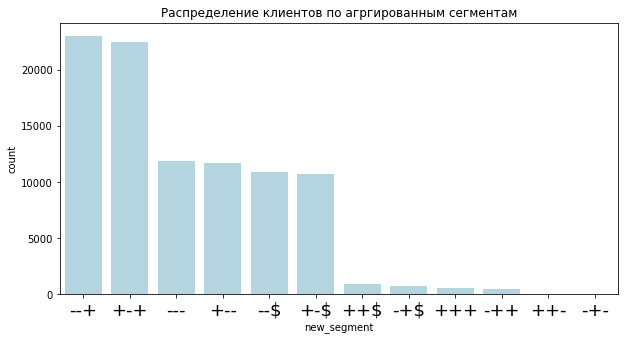

In [80]:
# Визуализируем распределение клиентов по сегментам
plt.figure(figsize=(10,5));
sns.countplot(x='new_segment',
              data=for_RFM_analysis_table,
              order=for_RFM_analysis_table['new_segment'].value_counts().index, color='lightblue')
plt.xticks(fontsize=18)
plt.title('Распределение клиентов по агрегированным сегментам');

1. **потерянные клиенты** — 49%: сегменты `--+`, `---`, `--$`  
2. **бывшие лояльные** — 1,4%: сегменты `-+$`, `-++`, `-+-`  
3. **новички** — 13%: сегмент `+--`
4. **сегмент китов** — 35%: сегменты `+-+`, `+-$` 
5. **перспективные** — менее 0,1 %: сегмент `++-`   
6. **идеальные** 1,6%: сегменты `+++`, `++$` 

,new_segment,monetary_value,customer_unique_id
9,--$,3833404.23,10846
3,+-$,3791447.18,10669
4,+-+,2092821.19,22449
10,--+,2083391.48,23030
0,++$,346446.85,941
5,+--,345452.25,11725
11,---,345323.85,11830
6,-+$,271869.11,729
1,+++,55164.91,531
7,-++,51212.65,496


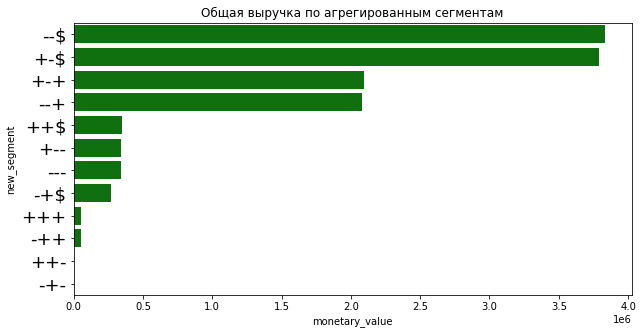

In [111]:
# Посмотрим в консолидированном виде также и на то, сколько всего денег принесли сегменты пользователей
for_RFM_analysis_table_groupby = for_RFM_analysis_table.groupby(['new_segment'], as_index=False) \
                                                       .agg({'monetary_value' : 'sum', 'customer_unique_id': 'count'}) \
                                                       .sort_values('monetary_value', ascending=False)

display(for_RFM_analysis_table_groupby)

plt.figure(figsize=(10,5));
sns.barplot(y='new_segment', x='monetary_value', data=for_RFM_analysis_table_groupby, color='green')
plt.xticks()
plt.yticks(fontsize=18)
plt.title('Общая выручка по агрегированным сегментам');

<div class="alert alert-success">   
    
**Основные выводы согласно выбранному подходу к RFM-анализу:**
    
___  
    
    
1. Половину клиентской базы составляют потерянные клиенты (заказывали давно и редко) и бывшие лояльные (когда-то заказывали часто). В качестве мер по возврату можно предложить рассылку с напоминанием и промокодом на покупку. Но в целом на эту категорию не стоит тратить много ресурсов, потому что, вероятно, их отток неизбежен. Гораздо больший практический интерес представляет выяснение причин оттока и работа над долгосрочной мотивацией клиентов.
___    
2. Чуть более трети клиентов составляют киты (которые купили недавно на большую сумму): их нужно постараться удержать и выяснить их потребности и интересы (для компании эти клиенты очень важны). И совсем незначителюную долю (менее 0,1 %) составляют клиенты, которые недавно и часто покупают, но на небольшую сумму: их необходимо замотивировать на поднятие среднего чека.
___         
3. 13% составляют новички, которых надо мотивировать на рост среднего чека и увеличение частоты покупок: с такими клиентами нужно активно работать.      
___     
4. И всего 1,6% — это наши идеальные клиенты: недавние, частые, с высоким чеком. Их всеми усилиями важно не потерять!
    
</div>